## **FORMULACIÓN PROBLEMA REDES**

En una red de distribución se tienen 3 origenes y 5 destinos. Los nodos de origen tienen una capacidad de envío y los nodos de destino tienen una demanda. Cada arco tiene asociado un costo fijo de enviar y un costo variable. Adicionalmente, hay arcos que no están disponibles. Escriba un modelo de optimización para decidir la cantidad se debe enviar de un nodo a otros minimizando los costos.

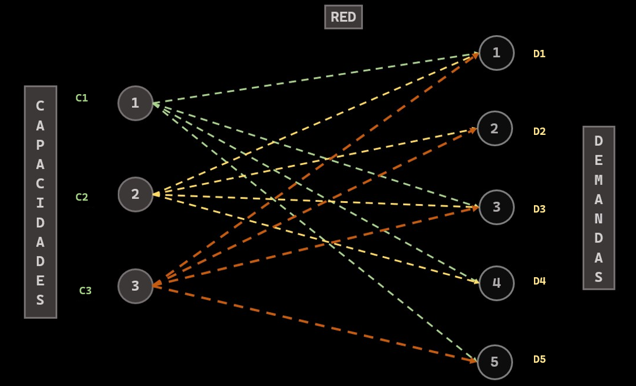

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;

| COSTO_VARIABLE | 1   | 2  | 3  | 4  | ... |
| -------------- | --: | -: | -: | -: | -:  |
| 1              | 6   | 20 | 14 | 18 | ... |
| 2              | 12  | 6  | 19 | 12 | ... |
| ...            | ... |... |... |... | ... |

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;

| COSTO_FIJO | 1   | 2   | 3    | 4   | ... |
| ---------- | --: | --: | ---: | --: | --: |
| 1          | 32  | 48  | 74   | 11  | ... |
| 2          | 12  | 61  | 191  | 52  | ... |
| ...        | ... |...  |...   |...  | ... |

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;

| BINARIO_NODOS | 1   | 2   | 3   | 4  | ... |
| ------------- | --: | --: | --: | -: | --: |
| 1             | 1   | 0   | 1   | 1  | ... |
| 2             | 1   | 1   | 1   | 1  | ... |
| ...           | ... |...  |...  |... | ... |

**RESTRICCIONES ADICIONALES**
1. Origen 3 no puede enviarle a 5 y a 1 al tiempo
2. Origen 3 puede enviarle máximo a 2 destinos
3. Si origen 1 envía a destino 20, entonces deberá enviar a destino 3 mínimo 7 unidades
4. Si el origen 13, le envia a 5 y 7, pero no a 15, entonces no le podra a 10
5. Si origen 2 envía a más de 4 destino, se penalizará en 1000 la funcion objetivo
6. Lo recibido por cada destino debe ser como mínimo igual a su faltante

In [1]:
import pandas
import gurobipy as gp
from gurobipy import GRB
import plotly.graph_objects as go

In [2]:
df_capacidades = pandas.read_excel("./data.xlsx", sheet_name="capacidades", index_col=0)
df_demandas = pandas.read_excel("./data.xlsx", sheet_name="demandas", index_col=0)
df_costo_fijo = pandas.read_excel("./data.xlsx", sheet_name="costo_fijo", index_col=0)
df_costo_variable = pandas.read_excel("./data.xlsx", sheet_name="costo_variable", index_col=0)
df_binario = pandas.read_excel("./data.xlsx", sheet_name="binario", index_col=0)

**Conjuntos**

$$ O: \text{Origenes} = \{1, 2,...,30\} $$
$$ D: \text{Destinos} = \{1, 2,...,50\} $$

In [3]:
ORIGENES = df_capacidades.index.to_list()
DESTINOS = df_demandas.index.to_list()

**Parámetros**

$$ \text{COSTO\_FIJO}_{od}: \text{costo fijo de enviar del origen } o\in O \text{ al destino } d\in D $$
$$ \text{COSTO\_VARIABLE}_{od}: \text{costo variable de enviar del origen } o\in O \text{ al destino } d\in D $$
$$ \text{BINARIO\_NODOS}_{od}: \left\{ \begin{array}{cl}
1\text{ Si el origen } o\in O \text{ puede enviar al destino } d\in D \\
0\text{ dlc}
\end{array} \right. $$
$$ \text{Capacidad}_{o}: \text{capacidad del origen } o\in O $$
$$ \text{Demanda}_{d}: \text{demanda del destino } d\in D $$

In [4]:
model = gp.Model()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-28


**Variables de decisión**

$$ x_{od} = \left\{ \begin{array}{cl}
1:\text{Si decido ir del origen } o\in O \text{ al destino } d\in D \\
0:\text{dlc}
\end{array} \right. $$
$$ w_{od}: \text{cantidad enviada del origen } o\in O \text{ al destino } d\in D $$
$$ F_{d}: \text{faltantes del destino } d\in D $$

In [5]:
X = model.addVars([(o, d) for o in ORIGENES for d in DESTINOS], vtype=GRB.BINARY, name="X")
W = model.addVars([(o, d) for o in ORIGENES for d in DESTINOS], vtype=GRB.CONTINUOUS, name="W")
F = model.addVars(DESTINOS, vtype=GRB.CONTINUOUS, name="F")
PHI = model.addVar(vtype=GRB.BINARY, name="PHI")

**Función Objetivo**

$$ \text{minimizar } \text{FO} = \sum_{o\in O}\sum_{d\in D} \text{COSTO\_FIJO}_{od} \times x_{od} + \sum_{o\in O}\sum_{d\in D} \text{COSTO\_VARIABLE}_{od} \times w_{od} + \mathcal{M} \times \sum_{d\in D} F_{d} + 100 * \phi $$

In [6]:
costo_fijo = gp.quicksum(df_costo_fijo.loc[o, d] * X[o, d] for o in ORIGENES for d in DESTINOS)
costo_variable = gp.quicksum(df_costo_variable.loc[o, d] * W[o, d] for o in ORIGENES for d in DESTINOS)
faltantes_totales = gp.quicksum(F[d] for d in DESTINOS)

## OPC1: FO una expresión
# model.setObjective(costo_fijo + costo_variable + 10000 * faltantes_totales)

## OPC2: FO multiobjetivo
model.setObjectiveN(faltantes_totales, index=0, priority=2, weight=1)
model.setObjectiveN(costo_fijo + costo_variable, index=1, priority=1, weight=1)
model.ModelSense = GRB.MINIMIZE

**Restricciones**

$$ \forall d \in D:\sum_{o\in O}w_{od} + F_{d} \ge \text{Demanda}_{d} $$

In [7]:
## Demanda
for d in DESTINOS:
    model.addConstr(gp.quicksum(W[o,d] for o in ORIGENES) + F[d]>= df_demandas.loc[d, "DEMANDA"])

$$ \forall o \in O:\sum_{d\in D}w_{od} \le \text{Capacidad}_{o} $$

In [8]:
## Capacidad
for o in ORIGENES:
    model.addConstr(gp.quicksum(W[o,d] for d in DESTINOS) <= df_capacidades.loc[o, "CAPACIDAD"])

$$ \forall o \in O \quad\forall d\in D:x_{od}\le \text{BINARIO\_NODOS}_{od} $$

In [9]:
## Parámetro binario
for o in ORIGENES:
    for d in DESTINOS:
        model.addConstr(X[o, d] <= df_binario.loc[o, d])

$$ \forall o \in O \quad\forall d\in D:w_{od} \le \mathcal{M} \times x_{od} $$

In [10]:
## Relación decisión de envío y cantidad enviada
for o in ORIGENES:
    for d in DESTINOS:
        model.addConstr(W[o,d] <= 100 * X[o, d])

$$ \forall d \in D:\sum_{o\in O}w_{od} \ge F_{d} $$

In [11]:
for d in DESTINOS:
    model.addConstr(gp.quicksum(W[o, d] for o in ORIGENES) >= F[d])

$$ x_{31} + x_{35} \le 1 $$

In [12]:
## Origen 3 no puede enviarle a 5 y a 1 al tiempo
model.addConstr(X["O_03", "D_01"] + X["O_03", "D_05"] <= 1)

<gurobi.Constr *Awaiting Model Update*>

$$ \sum_{d\in D} w_{3d} \le  2 $$

In [13]:
## Origen 3 puede enviarle máximo a 2
model.addConstr(gp.quicksum(X["O_03", d] for d in DESTINOS) <= 2)

<gurobi.Constr *Awaiting Model Update*>

$$ w_{1,3} \ge 7 - \mathcal{M} * (1 - x_{1,20})

In [14]:
## OPC1
# model.addGenConstrIndicator(X["O_01", "D_20"], True, W["O_01", "D_01"] >= 7)

## OPC 2
model.addConstr((X["O_01", "D_20"] == 1) >> (W["O_01", "D_01"] >= 7))

<gurobi.GenConstr *Awaiting Model Update*>

$$ 3 - (x_{13,5} + x_{13,7} + (1 - x_{13,15})) \geq x_{13,10}  $$

In [15]:
# model.addGenConstrAnd(1 - X["O_13", "D_30"], [X["O_13", "D_05"], X["O_13", "D_07"], 1 - X["O_13", "D_15"]])
model.addConstr(X["O_13", "D_30"] <= 3 - (X["O_13", "D_05"] + X["O_13", "D_07"] + (1 - X["O_13", "D_15"])))

<gurobi.Constr *Awaiting Model Update*>

$$ \mathcal{M} \phi \le \mathcal{M} + (\sum_{d\in D} x_{2d}-3.5) $$
$$ \mathcal{M} \phi \ge (\sum_{d\in D} x_{2d}-3.5) $$

In [16]:
## Si origen 2 envía a más de 4 destino, se penalizará en 100 la funcion objetivo
model.addConstr(10 * PHI <= 10 + (gp.quicksum(X["O_02", d] for d in DESTINOS) - 3.5))
model.addConstr(10 * PHI >= gp.quicksum(X["O_02", d] for d in DESTINOS) - 3.5)

<gurobi.Constr *Awaiting Model Update*>

In [17]:
model.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3135 rows, 3051 columns and 9258 nonzeros
Model fingerprint: 0x0fea6f48
Model has 1 general constraint
Variable types: 1550 continuous, 1501 integer (1501 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+01]
  GenCon rhs range [7e+00, 7e+00]
  GenCon coe range [1e+00, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

In [18]:
fig = go.Figure()
fig.add_trace(go.Bar(x=DESTINOS, y=[sum(W[o, d].X for o in ORIGENES) for d in DESTINOS], name="Envío"))
fig.add_trace(go.Bar(x=DESTINOS, y=[F[d].X for d in DESTINOS], name="Faltantes"))


fig.update_layout(
    title=f"<b>CANTIDAD RECIBIDA Y FALTANTES DESTINOS<br />Costo Fijo: {costo_fijo.getValue():.2f} - Costo Variable: {costo_variable.getValue():.2f}<br />Faltantes Totales: {faltantes_totales.getValue():.0f}</b>",
    xaxis=dict(title="Destinos"),
    yaxis=dict(title="Cantidades"),
    barmode="group",
    width=1200,
    template="ggplot2",
)

fig.show()